In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, save_pd_df
from matplotlib.pyplot import cm

from patsy import dmatrix
import pymc as pm
import arviz as az

from src.pymc_modelling import get_samp
from src.nlp_utils import evalute_optimal_smoothing
from src.utils import save_fig

In [14]:
tdet = load_pd_df("det_topics.feather")
tlda = load_pd_df("lda_topics.feather").reset_index()

# plot

In [4]:
tdet_g = tdet.drop('id', axis=1).groupby('date').sum() #/ tdet.drop('id', axis=1).groupby('date').count().iloc[:,0].values[:,None]
tdet_g = tdet_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

tlda_g = tlda.drop('id', axis=1).groupby('date').sum() #/ tlda.groupby('date').count().iloc[:,0].values[:,None]
tlda_g = tlda_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

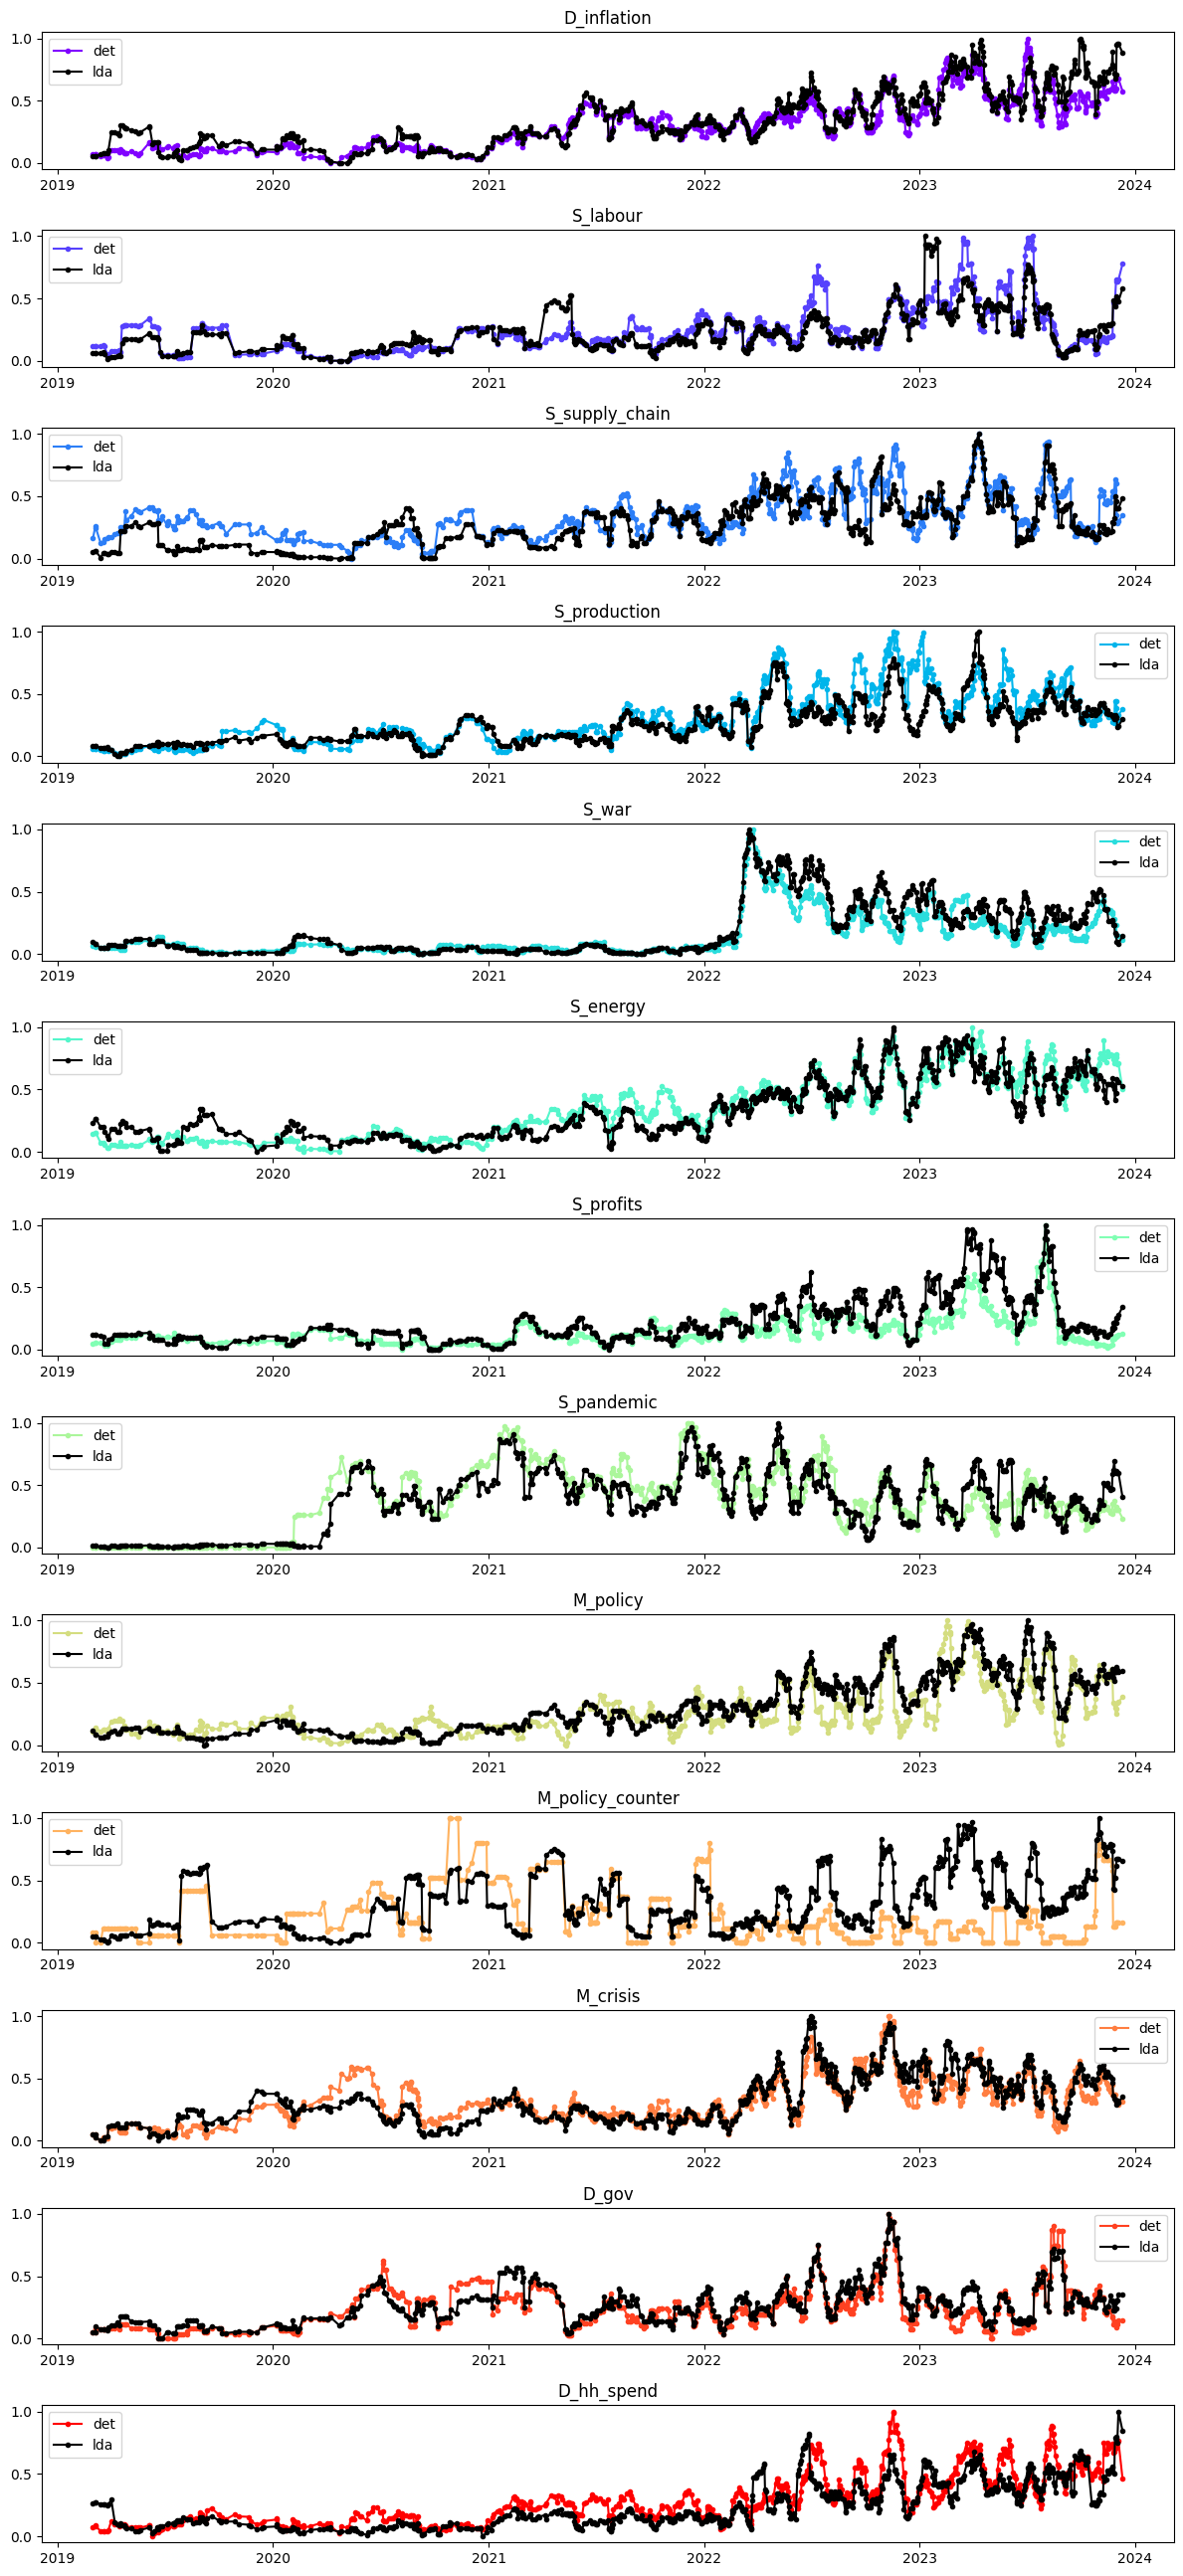

In [5]:
nrows = tdet_g.shape[1]
fig, axes = plt.subplots(nrows, 1, figsize=(12, 2 * nrows))
color = cm.rainbow(np.linspace(0, 1, nrows))

for i, ax in enumerate(axes.ravel()):
    col = tdet_g.columns[i]
    ax.plot(tdet_g.iloc[:, i], c=color[i], marker='.', )
    ax.plot(tlda_g.loc[:, col], c='black', marker='.',)
    ax.set_title(label=col)
    ax.legend(['det', 'lda'])
            
plt.tight_layout()
save_fig(fig, "02_topics_raw_det_lda.png")

# smooth

In [ ]:
%%capture
dict_compare_az, dict_best_nknot, dict_compare_traces, dict_data_grouped = {}, {}, {}, {}
for col in tlda.drop(['date', 'id'], axis=1).columns:
    
    g = tlda.groupby('date')[col].sum().replace({0: np.nan})
    
    az_df, mods, traces = evalute_optimal_smoothing(g, search_range=range(5, 65, 5))
    dict_best_nknot[col] = az_df[az_df['rank'] == 0].index[0]
    dict_compare_az[col] = az_df
    dict_compare_traces[col] = traces
    dict_data_grouped[col] = g

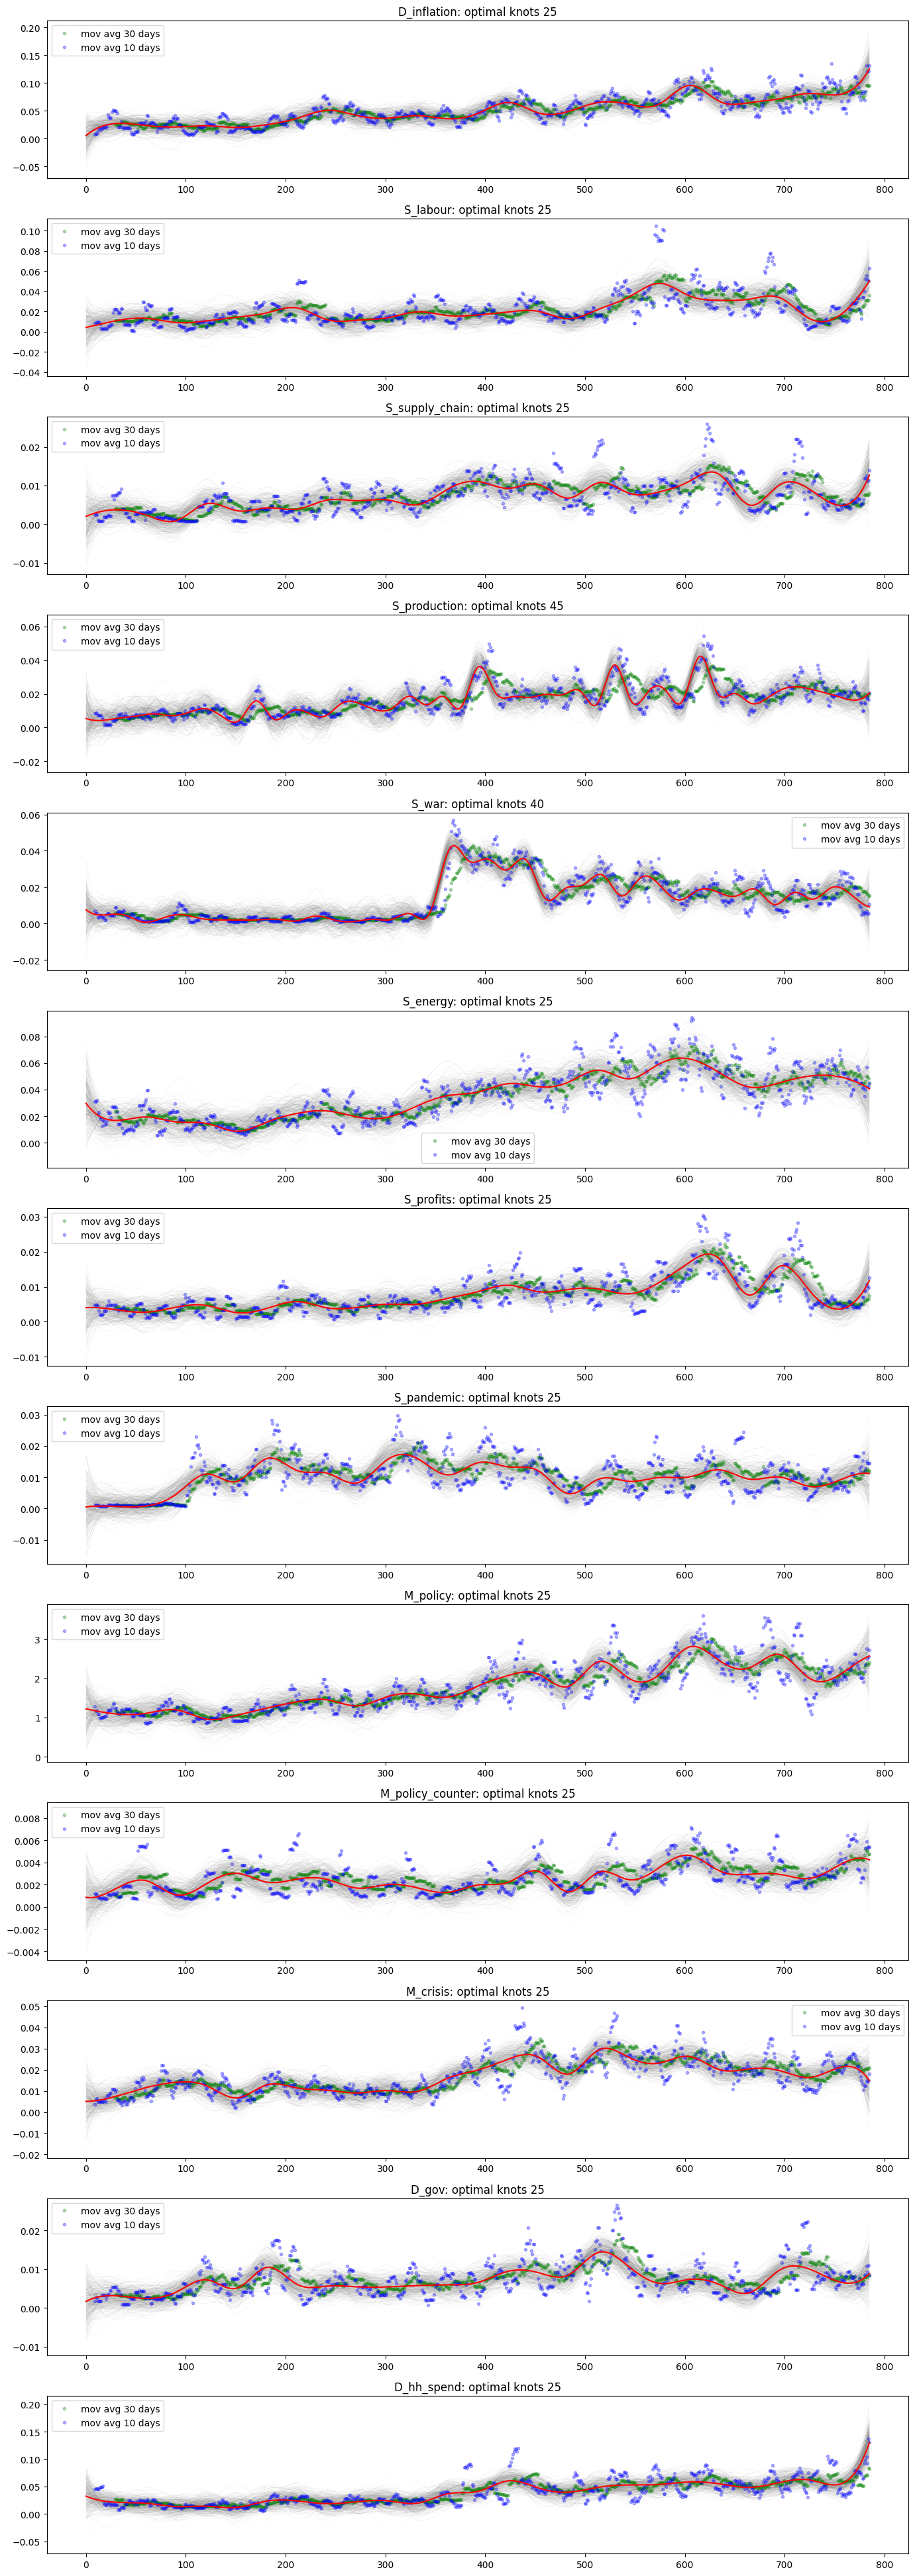

In [5]:
dict_smoothed = {}
dict_plot = {col: [dict_data_grouped[col], dict_compare_traces[col][v]] for col, v in dict_best_nknot.items()}

fig, axes = plt.subplots(len(dict_plot), 1, figsize=(14,3*len(dict_plot)))
for i, _ in enumerate(dict_plot.items()):
    col, _ = _
    data, trace = _
    
    axes.ravel()[i].set_title(f"{col}: optimal knots {dict_best_nknot[col]}") #f"knots_{trace.posterior['beta'].shape[-1]-2}", size=8)
    axes.ravel()[i].plot(
        trace.posterior['mu'][:, get_samp(1_000, 200)].values.reshape(2*200, g.shape[0]).T,
        lw=.1,
        alpha=.3,
        color='grey',
    )
    axes.ravel()[i].plot(data.rolling(30).mean().values, lw=0, marker='.', color='green', alpha=.3, label='mov avg 30 days')
    axes.ravel()[i].plot(data.rolling(10).mean().values, lw=0, marker='.', color='blue', alpha=.3, label='mov avg 10 days')
    axes.ravel()[i].plot(trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, g.shape[0]).T.mean(axis=1), color='red')
    axes.ravel()[i].legend()
    
    dict_smoothed[col] = trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, g.shape[0]).T.mean(axis=1)
plt.tight_layout();
save_fig(fig, "02_topics_smooth_det_lda.png")

In [6]:
tlda['date'] = tlda['date'].apply(lambda x: datetime(x.year, x.month, x.day))
tlda = tlda.set_index('date').join(pd.DataFrame(dict_smoothed, index=tlda.date.drop_duplicates()).add_suffix('_s'), how='left')

In [11]:
save_pd_df(tlda, 'lda_topics_smooth.feather')